In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
from tensorflow import keras

# LSTM Proof of Concept

Before we jump straight into using LSTMs to help us handle real-time 5-minute prediction, let's try getting the bare-bones of the model running!

To do this, we will first utilize hourly aggregate data, so that we're not giving DeepNote a complete meltdown.

In [ ]:
raw_data = pd.read_csv("/work/CAISO_data.csv")

In [ ]:
data = raw_data.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp') # Next line requires DateTimeIndex to function properly
data = data.resample('H').sum() # This functions like a groupby statement on hour

# Sort by time for readability
data = data.reset_index().sort_values('timestamp', ascending=True).set_index('timestamp') 
data.head()

,Unnamed: 0,load_MW
timestamp,,
2015-01-01 08:00:00+00:00,1377,269994.0
2015-01-01 09:00:00+00:00,1765,259722.0
2015-01-01 10:00:00+00:00,1314,252780.0
2015-01-01 11:00:00+00:00,1791,247985.0
2015-01-01 12:00:00+00:00,1580,247700.0


In [ ]:
len(data)

70128

In [ ]:
# Convert data to proper format for training
def create_dataset(dataset, look_back=1):
    """
    Returns two numpy arrays corresponding to the 
    features to train on and their corresponding labels, respectively.

    Inputs:
        dataset: raw training data with time as index and rows as electricity demand
        look_back: how far back we would like our model to look back to make the next prediction
    """
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 8  # Number of previous hours to consider
X, Y = create_dataset(data['load_MW'].to_numpy().reshape([len(data), 1]), look_back)

# There are some NaNs in our data, removing them for simplicity
unclean_dataset = pd.DataFrame(X)
unclean_dataset['y'] = Y
clean_dataset = unclean_dataset[unclean_dataset.isna().sum(axis=1) == 0]

# ...like there were never any NaNs to begin with :D
Y = clean_dataset['y'].to_numpy()
X = clean_dataset.drop('y', axis=1).to_numpy()

# Splitting the dataset into Training and Test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]

In [ ]:
# Reshape input to be [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

keras.backend.clear_session()
# Create and fit the LSTM network
model3 = keras.Sequential()
model3.add(keras.Input(shape=(look_back, 1)))
model3.add(LSTM(100, input_shape=(look_back, 1)))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='sgd')

In [ ]:
# Proof of concept: checking to see if the model errors or yields erroneous results
model3.fit(train_X[:250, :, :], train_Y[:250], epochs=1000, batch_size=32, verbose=1)

Epoch 1/1000
8/8 [==============================] - 1s 12ms/step - loss: 59653848746164224.0000
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 132853799059456.0000
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 96160517718016.0000
Epoch 4/1000
8/8 [==============================] - 0s 13ms/step - loss: 69602126069760.0000
Epoch 5/1000
8/8 [==============================] - 0s 12ms/step - loss: 50378326409216.0000
Epoch 6/1000
8/8 [==============================] - 0s 13ms/step - loss: 36463735472128.0000
Epoch 7/1000
8/8 [==============================] - 0s 12ms/step - loss: 26392901189632.0000
Epoch 8/1000
8/8 [==============================] - 0s 4ms/step - loss: 19103494438912.0000
Epoch 9/1000
8/8 [==============================] - 0s 4ms/step - loss: 13827569614848.0000
Epoch 10/1000
8/8 [==============================] - 0s 13ms/step - loss: 10008689377280.0000
Epoch 11/1000
8/8 [==============================] - 0s 12ms/step - l

KeyboardInterrupt: 

In [ ]:
# np.sqrt(model3.history.history['loss'])

In [ ]:
# RMSE from running one epoch
np.sqrt(model3.history.history['loss'])

array([1.37364223e+06, 1.34616937e+06, 1.31924602e+06, 1.29286098e+06,
       1.26700387e+06, 1.24166376e+06, 1.21683050e+06, 1.19249400e+06,
       1.16864401e+06, 1.14527127e+06, 1.12236572e+06, 1.09991847e+06,
       1.07791997e+06, 1.05636172e+06, 1.03523444e+06, 1.01452974e+06,
       9.94239141e+05, 9.74354362e+05, 9.54867303e+05, 9.35769928e+05,
       9.17054568e+05, 8.98713514e+05, 8.80739232e+05, 8.63124454e+05,
       8.45861927e+05, 8.28944682e+05, 8.12365813e+05, 7.96118512e+05,
       7.80196110e+05, 7.64592205e+05, 7.49300368e+05, 7.34314369e+05,
       7.19628067e+05, 7.05235489e+05, 6.91130758e+05, 6.77308127e+05,
       6.63761991e+05, 6.50486756e+05, 6.37477011e+05, 6.24727496e+05,
       6.12232871e+05, 5.99988255e+05, 5.87988505e+05, 5.76228762e+05,
       5.64704115e+05, 5.53410069e+05, 5.42341876e+05, 5.31494997e+05,
       5.20865124e+05, 5.10447807e+05, 5.00238870e+05, 4.90234101e+05,
       4.80429410e+05, 4.70820819e+05, 4.61404368e+05, 4.52176319e+05,
      

In [ ]:
train_Y[:5000]

array([257274., 247827., 242481., ..., 310526., 332580., 354238.])

In [ ]:
train_predict = model3.predict(train_X[:5000, :, :])
pd.DataFrame(train_predict)

157/157 [==============================] - 1s 7ms/step


,0
0,257273.625
1,257273.625
2,257273.625
3,257273.625
4,257273.625
...,...
4995,257273.625
4996,257273.625
4997,257273.625
4998,257273.625


(array([  486., 14066., 17391., 13258.,  4917.,  2628.,  1699.,   832.,
          242.,    28.]),
 array([14104.4425    , 17606.08991667, 21107.73733333, 24609.38475   ,
        28111.03216667, 31612.67958333, 35114.327     , 38615.97441667,
        42117.62183333, 45619.26925   , 49120.91666667]),
 <BarContainer object of 10 artists>)

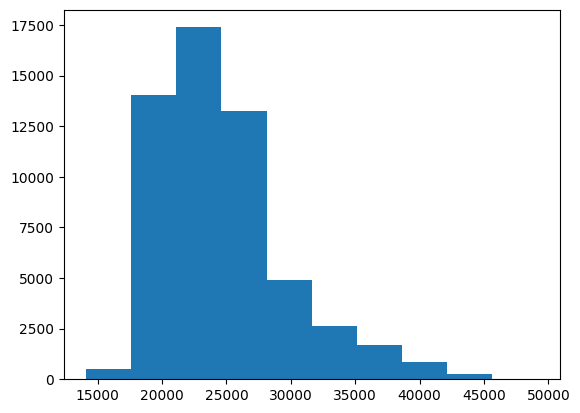

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_Y)

In [ ]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Invert predictions
train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

def mse(predicted, actual):
    return np.mean((predicted - actual) ** 2)

# Calculate root mean squared error
train_score = np.sqrt(mse(train_Y[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = np.sqrt(mse(test_Y[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

1150/1752 [==================>...........] - ETA: 10s

KeyboardInterrupt: 

In [ ]:
# Plotting baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(np.concatenate((train_predict, test_predict)))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b82b9643-cfd7-4eed-98d3-bc210272c836' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>